# Load the data 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
admissions = pd.read_csv('../data/core/admissions.csv')
patients = pd.read_csv('../data/core/patients.csv')
diagnose = pd.read_csv('../data/hosp/d_icd_diagnoses.csv')
subj_diagnose = pd.read_csv('../data/hosp/diagnoses_icd.csv')


In [3]:
def get_cohort(icd_number):
    df1=patients.set_index('subject_id')
    df2=subj_diagnose[subj_diagnose['icd_code'].str.contains(str(icd_number))].drop_duplicates('subject_id', keep='first').set_index('subject_id')
    data = df2.join(df1,how='left')
    data['dod']=data['dod'].replace(np.nan, 0, regex=True)
    data['dod']=data['dod'].replace('-', 1, regex=True)

    return data

def mortality_rate(df):
    return np.count_nonzero(df['dod']==1)/len(df['dod'])

In [4]:
cohort = get_cohort('I61')
print('cohort size', cohort.shape[0])
print('mortality_rate', mortality_rate(cohort))
cohort

cohort size 1331
mortality_rate 0.24417731029301276


,hadm_id,seq_num,icd_code,icd_version,gender,anchor_age,anchor_year,anchor_year_group,dod
subject_id,,,,,,,,,
12987308,29175492,2,I615,10,F,66,2129,2014 - 2016,0
18431316,21877054,2,I614,10,M,71,2134,2014 - 2016,0
13502902,22115430,3,I615,10,F,56,2160,2014 - 2016,0
17096041,24581169,1,I618,10,M,75,2120,2014 - 2016,0
12675886,28521489,5,I611,10,M,62,2177,2014 - 2016,0
...,...,...,...,...,...,...,...,...,...
14050724,20952526,1,I615,10,F,57,2112,2011 - 2013,0
12557389,21294125,1,I613,10,F,79,2151,2017 - 2019,0
18065731,25556934,1,I618,10,M,46,2137,2011 - 2013,0


# Select Features

In [5]:
def get_data(cohort_index, data_table, index_colname):
    return data_table[data_table[index_colname].isin(cohort_index)]

In [6]:
def fill_na_mean(df, rd=2, inplace=True):
    for col in list(df.columns[df.isnull().sum() > 0]):
        mean_val = df[col].mean()
        if inplace:
            try:
                df[col].fillna(round(mean_val,rd),inplace=inplace)
            except TypeError:
                continue
        else:
            try:
                df = df[col].fillna(round(mean_val,rd))
            except TypeError:
                continue
    if not inplace:
        return df

In [7]:
cohort_ind = cohort.index

## Load Vital Signs




In [8]:
vital_raw = pd.read_csv('../data/ed/vitalsign.csv')
vital_raw.head()

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,16113983,37539106,2116-06-10 00:32:00,98.2,82.0,15.0,NaN,106.0,72.0,NaN,NaN
1,15128994,30058281,2167-08-29 02:25:00,98.3,79.0,20.0,97.0,126.0,73.0,NaN,0
2,15128994,30058281,2167-08-29 04:51:00,97.6,79.0,20.0,98.0,126.0,73.0,NaN,0
3,15128994,30058281,2167-08-29 05:35:00,98.3,76.0,18.0,NaN,123.0,68.0,NaN,0/10
4,18019452,37300626,2148-12-19 12:34:00,98.1,100.0,16.0,98.0,129.0,86.0,NaN,0


In [9]:
# Drop rhythm, pain which have a lot of missing data
vital_id = get_data(cohort_ind, vital_raw, 'subject_id' ).iloc[:,:-2]
vital_id.head()

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp
1903,16867282,33209161,2146-07-23 01:41:00,97.6,96.0,16.0,96.0,99.0,75.0
1904,16867282,33209161,2146-07-23 02:42:00,NaN,88.0,20.0,96.0,155.0,101.0
1905,16867282,33209161,2146-07-23 03:27:00,NaN,106.0,21.0,95.0,160.0,95.0
1906,16867282,33209161,2146-07-23 04:34:00,NaN,97.0,15.0,97.0,148.0,76.0
1907,16867282,33209161,2146-07-23 05:27:00,97.5,80.0,16.0,95.0,142.0,111.0


In [10]:
fill_na_mean(vital_id)
vital_id

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp
1903,16867282,33209161,2146-07-23 01:41:00,97.60,96.00,16.0,96.00,99.0,75.0
1904,16867282,33209161,2146-07-23 02:42:00,97.37,88.00,20.0,96.00,155.0,101.0
1905,16867282,33209161,2146-07-23 03:27:00,97.37,106.00,21.0,95.00,160.0,95.0
1906,16867282,33209161,2146-07-23 04:34:00,97.37,97.00,15.0,97.00,148.0,76.0
1907,16867282,33209161,2146-07-23 05:27:00,97.50,80.00,16.0,95.00,142.0,111.0
...,...,...,...,...,...,...,...,...,...
1650414,12557389,35529368,2153-01-24 21:47:00,97.37,86.00,18.0,92.00,136.0,117.0
1650415,12557389,35529368,2153-01-24 22:02:00,97.37,81.41,29.0,97.49,110.0,88.0
1650416,12557389,35529368,2153-01-24 22:16:00,97.37,79.00,24.0,95.00,127.0,63.0
1650417,12557389,35529368,2153-01-24 23:01:00,97.37,74.00,28.0,93.00,119.0,62.0


In [11]:
vital_id =vital_id.drop_duplicates('subject_id', keep='last').set_index('subject_id')

In [12]:
vital_id.head()

,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp
subject_id,,,,,,,,
12149325,34924758,2181-04-30 01:21:00,98.30,80.0,17.0,100.0,113.0,73.0
18208117,33149488,2196-08-09 17:31:00,97.37,89.0,16.0,99.0,134.0,51.0
13758211,36323005,2187-03-07 03:40:00,98.00,78.0,18.0,94.0,103.0,64.0
13802667,32065382,2124-04-21 00:16:00,97.90,63.0,16.0,99.0,138.0,89.0
12442793,39215109,2182-04-15 06:00:00,97.60,76.0,11.0,100.0,140.0,82.0


In [13]:
final = cohort.join(vital_id)
final.shape

(1331, 17)

## Load chartted Event

In [14]:
# Select data From Google Bigquery using SQL
# This command took 20 mins to run, returns 10 milion rows of data.
# So won't run it here, we saved the output locally and then load it. 
'''
project_id = 'focus-dragon-313813'

df = pd.io.gbq.read_gbq(f"""SELECT * 
FROM `physionet-data.mimic_icu.chartevents`
WHERE subject_id in {tuple(cohort.index.values.tolist())}
ORDER BY subject_id""", project_id='focus-dragon-313813', dialect='standard')'''

'\nproject_id = \'focus-dragon-313813\'\n\ndf = pd.io.gbq.read_gbq(f"""SELECT * \nFROM `physionet-data.mimic_icu.chartevents`\nWHERE subject_id in {tuple(cohort.index.values.tolist())}\nORDER BY subject_id""", project_id=\'focus-dragon-313813\', dialect=\'standard\')'

In [15]:
# Selected Features from table event

# PH (Venous)
# Chloride (serum)
# Creatinine (serum)
# Magnesium
# Sodium (serum)
# PH (dipstick)
# Sodium Bicarbonate 8.4%
# Norepinephrine
# Magnesium Sulfate
# PH (Arterial)
# GCS - Verbal Response
# Heparin Sodium
# Chloride (whole blood)
# CreatinineApacheIIScore
# CreatinineApacheIIValue
# HematocritApacheIIScore
# WbcApacheIIScore
# WBCApacheIIValue
# Hematocrit_ApacheIV
# HR_ApacheIV
# WBC_ApacheIV
# WBCScore_ApacheIV
# Magnesium Sulfate (Bolus)
# Chloride (serum) (soft)
# Sodium (serum) (soft)
# Creatinine (whole blood)
# selected_items = [220274,220602,220615,220635,220645,220734,220995,221906,222011,223830,223900,
# 225152,226536,226751,226752,226761,226779,226780,227017,227018,227062,227063,227523,228385,228389,229761,]

In [16]:
# df[df['itemid'].isin(selected_items)].to_csv('chart_event_filtered.csv')

In [17]:
# len(df['itemid'].unique())

In [18]:
charteve_raw = pd.read_csv('../data/chart_event_filtered.csv')
charteve_raw.head()

,Unnamed: 0,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,24,10007677,27180483,34992648,2120-11-21 12:00:00,2120-11-21 13:48:00,223900,Oriented,5.0,NaN,0
1,78,10007677,27180483,34992648,2120-11-17 20:00:00,2120-11-17 20:52:00,223900,Oriented,5.0,NaN,0
2,117,10007677,27180483,34992648,2120-11-21 18:48:00,2120-11-21 19:40:00,220645,130,130.0,mEq/L,1
3,159,10007677,27180483,34992648,2120-11-19 12:00:00,2120-11-19 11:59:00,223900,Oriented,5.0,NaN,0
4,220,10007677,27180483,34992648,2120-11-19 00:40:00,2120-11-19 00:40:00,223900,Oriented,5.0,NaN,0


In [19]:
item_names = pd.read_csv('../data/icu/d_items.csv').set_index('itemid')
item_names.head()

,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
itemid,,,,,,,,
220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN
220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,NaN,Text,NaN,NaN


In [20]:
item_dict = dict()
for item_id in charteve_raw['itemid'].unique():
    item_dict[item_id] = item_names.loc[item_id, 'abbreviation']

In [21]:
# This command takes a few minutes to run.
for i in range(charteve_raw.shape[0]):
    entry = charteve_raw.iloc[i,:]
    sub_id, itemid = entry[['subject_id', 'itemid']]
    item_names = item_dict[itemid]
    final.loc[sub_id, item_names] = entry['valuenum']
final.head() 

,hadm_id,seq_num,icd_code,icd_version,gender,anchor_age,anchor_year,anchor_year_group,dod,stay_id,...,Verbal Response,Sodium (serum),Chloride (serum),Magnesium,Creatinine (serum),PH (dipstick),PH (Venous),PH (Arterial),Creatinine (whole blood),Chloride (whole blood)
subject_id,,,,,,,,,,,,,,,,,,,,,
12987308,29175492,2,I615,10,F,66,2129,2014 - 2016,0,NaN,...,1.0,136.0,111.0,2.1,0.6,6.0,NaN,7.47,NaN,NaN
18431316,21877054,2,I614,10,M,71,2134,2014 - 2016,0,33707820.0,...,1.0,135.0,122.0,2.0,1.0,8.5,7.43,7.48,NaN,NaN
13502902,22115430,3,I615,10,F,56,2160,2014 - 2016,0,39213996.0,...,1.0,150.0,114.0,2.0,0.5,8.0,NaN,7.48,NaN,NaN
17096041,24581169,1,I618,10,M,75,2120,2014 - 2016,0,38109347.0,...,1.0,141.0,97.0,2.3,1.1,5.0,7.34,7.33,NaN,NaN
12675886,28521489,5,I611,10,M,62,2177,2014 - 2016,0,32771920.0,...,2.0,138.0,102.0,2.2,0.8,NaN,7.36,7.48,NaN,98.0


In [22]:
test = final.iloc[:,:-5].dropna(how='any',axis=0)
test[['dod']] = test[['dod']].astype('int')
test.describe()

,hadm_id,seq_num,icd_version,anchor_age,anchor_year,dod,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,Verbal Response,Sodium (serum),Chloride (serum),Magnesium,Creatinine (serum)
count,1.032000e+03,1032.000000,1032.0,1032.000000,1032.000000,1032.000000,1.032000e+03,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000
mean,2.490868e+07,3.017442,10.0,67.600775,2151.091085,0.230620,3.505354e+07,97.214254,80.047016,18.130620,97.499719,130.582529,71.054864,3.290698,141.391473,104.860465,2.067539,1.095058
std,2.835172e+06,4.114002,0.0,14.927744,23.458559,0.421434,2.922054e+06,6.471891,16.569457,3.394781,3.619681,18.585877,13.743655,1.754250,5.719082,6.414695,0.300473,1.006297
min,2.000251e+07,1.000000,10.0,19.000000,2110.000000,0.000000,3.000467e+07,32.400000,7.000000,4.000000,2.000000,31.000000,23.000000,1.000000,116.000000,84.000000,0.400000,0.200000
25%,2.244252e+07,1.000000,10.0,59.000000,2130.750000,0.000000,3.256712e+07,97.370000,69.000000,16.000000,96.000000,118.000000,62.000000,1.000000,138.000000,101.000000,1.900000,0.600000
50%,2.483408e+07,2.000000,10.0,69.000000,2150.000000,0.000000,3.492956e+07,97.600000,80.000000,18.000000,98.000000,131.500000,71.000000,4.000000,141.000000,104.000000,2.000000,0.800000
75%,2.719470e+07,3.000000,10.0,79.000000,2172.000000,0.000000,3.769880e+07,98.200000,89.000000,19.000000,100.000000,141.000000,78.000000,5.000000,144.000000,108.000000,2.200000,1.100000
max,2.999962e+07,38.000000,10.0,91.000000,2205.000000,1.000000,3.998928e+07,105.000000,171.000000,44.000000,100.000000,206.000000,145.000000,5.000000,171.000000,140.000000,4.000000,12.800000


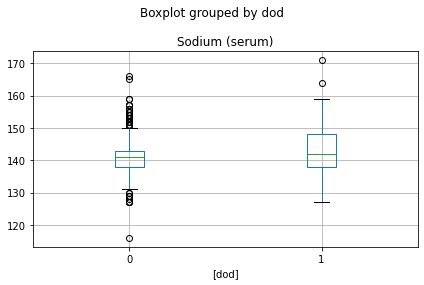

In [23]:
test[['dod', 'Sodium (serum)' ]].boxplot(by='dod')
plt.tight_layout()

# Description

In [24]:
test.dtypes

hadm_id                 int64
seq_num                 int64
icd_code               object
icd_version             int64
gender                 object
anchor_age              int64
anchor_year             int64
anchor_year_group      object
dod                     int64
stay_id               float64
charttime              object
temperature           float64
heartrate             float64
resprate              float64
o2sat                 float64
sbp                   float64
dbp                   float64
Verbal Response       float64
Sodium (serum)        float64
Chloride (serum)      float64
Magnesium             float64
Creatinine (serum)    float64
dtype: object

# Logistic Regression

In [25]:
test[test.dod==0].shape[0]/test.shape[0]

0.7693798449612403

In [26]:
from sklearn.linear_model import LogisticRegression
X = test[['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp',
       'Verbal Response', 'Sodium (serum)', 'Chloride (serum)', 'Magnesium',
       'Creatinine (serum)']]
y = test['dod']
clf = LogisticRegression(random_state=0).fit(X, y)

clf.score(X, y)

/home/jzni/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8187984496124031

---------------------
# Find dod ID


In [27]:
# fillnan_test.set_index('subject_id',inplae=True)

In [33]:
# dod_id=cohort[cohort['dod']==1]
# test = dod_id.join(fillnan_test,how='left')
# np.count_nonzero(test['stay_id']>1)

In [34]:
dod_id

,hadm_id,seq_num,icd_code,icd_version,gender,anchor_age,anchor_year,anchor_year_group,dod
subject_id,,,,,,,,,
12975809,23301191,3,I615,10,F,67,2145,2014 - 2016,1
18208117,24530240,1,I610,10,F,67,2189,2008 - 2010,1
14898984,20037890,1,I619,10,M,79,2141,2014 - 2016,1
10356145,20548235,1,I618,10,F,67,2154,2008 - 2010,1
19599279,21669500,5,I619,10,M,70,2187,2008 - 2010,1
...,...,...,...,...,...,...,...,...,...
10667727,24639827,2,I611,10,F,76,2147,2014 - 2016,1
13900699,24480665,2,I610,10,M,68,2128,2017 - 2019,1
19297868,25776572,4,I618,10,F,48,2188,2017 - 2019,1


In [35]:
test['stay_id']

subject_id
18431316    33707820.0
13502902    39213996.0
17096041    38109347.0
12675886    32771920.0
18534781    39370780.0
               ...    
10445331    36376053.0
16633337    34596000.0
12557389    35529368.0
18065731    30340314.0
12853711    38437051.0
Name: stay_id, Length: 1032, dtype: float64

# Load output event

In [28]:
outevents = pd.read_csv('../data/icu/outputevents.csv')
itmes = pd.read_csv('../data/icu/d_items.csv')

In [29]:
test_main = cohort.copy()

In [30]:
out = outevents[outevents['subject_id'].isin(test_main.index)]

In [31]:
for i in range(out.shape[0]):
    entry = out.iloc[i,:]
    sub_id, itemid = entry[['subject_id', 'itemid']]
    test_main.loc[sub_id, itemid] = entry['value']
test_main.head() 

,hadm_id,seq_num,icd_code,icd_version,gender,anchor_age,anchor_year,anchor_year_group,dod,226560,...,226597,226600,226601,226584,229413,226564,226630,226605,226557,226603
subject_id,,,,,,,,,,,,,,,,,,,,,
12987308,29175492,2,I615,10,F,66,2129,2014 - 2016,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18431316,21877054,2,I614,10,M,71,2134,2014 - 2016,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13502902,22115430,3,I615,10,F,56,2160,2014 - 2016,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17096041,24581169,1,I618,10,M,75,2120,2014 - 2016,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12675886,28521489,5,I611,10,M,62,2177,2014 - 2016,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
